# Flood Mapping from Single Sentinel-1 SAR Images

This notebook presents a SAR-based flood mapping approach that largely follows a methodology developed by the German Aerospace Center and published in <cite><a href="https://www.tandfonline.com/doi/full/10.1080/01431161.2016.1192304"><i>Sentinel-1-based flood mapping: a fully automated processing chain</i></a> by Twele et al.</cite>. The approach is based on radiometricall terrain corrected (RTC processed) Sentinel-1 SAR data and applies a dynamic thresholding method followed by fuzzy-logic-based post processing procedure. This notebook implements the initial threshold-based flood mapping approach but, for simplicity, does not include the fuzzy-logic post processing steps. The approach is based on image amplitude data and is capable of detecting standing surface water. Note that flooding under vegetation will not be detected by this approach.

This notebook has been adapted from the the [Binder_Hazard_Labs_Flood](https://mybinder.org/v2/gh/ASFBinderRecipes/Binder_SAR_Hazards_Floods/main?labpath=SARHazards_Lab_Floods.ipynb) elaborated by Alaska Satellite Facility (ASF)and further information can be found by visiting NASA's training course [ARSET - SAR for Detecting and Monitoring Floods, Sea Ice, and Subsidence from Groundwater Extraction](https://appliedsciences.nasa.gov/get-involved/training/english/arset-sar-detecting-and-monitoring-floods-sea-ice-and-subsidence).

# Case Study: Floods in Trinidad and Tobago

In this Notebook, we are going to process two Sentinel-1 images from October, 2018. On 18 - 19 October of that year, Trinidad and Tobago experienced torrential rainfall. According to Government officials, Trinidad alone received a full month’s worth of rain during the two days. It was estimated 80% of the country was affected by flooding—communities, main roads, and public services were impacted ([Source](https://reliefweb.int/report/trinidad-and-tobago/trinidad-and-tobago-floods-and-landslides-due-intense-rains-23-10-2018)). A Sentinel-1 image was acquired over Trinidad island on the 19th, where the flooded areas can clearly be observed in blue color when creating an RGB. This image will be compared to a pre-event Sentinel-1 image (2018-10-07) in order to assess the extent of the flooding.

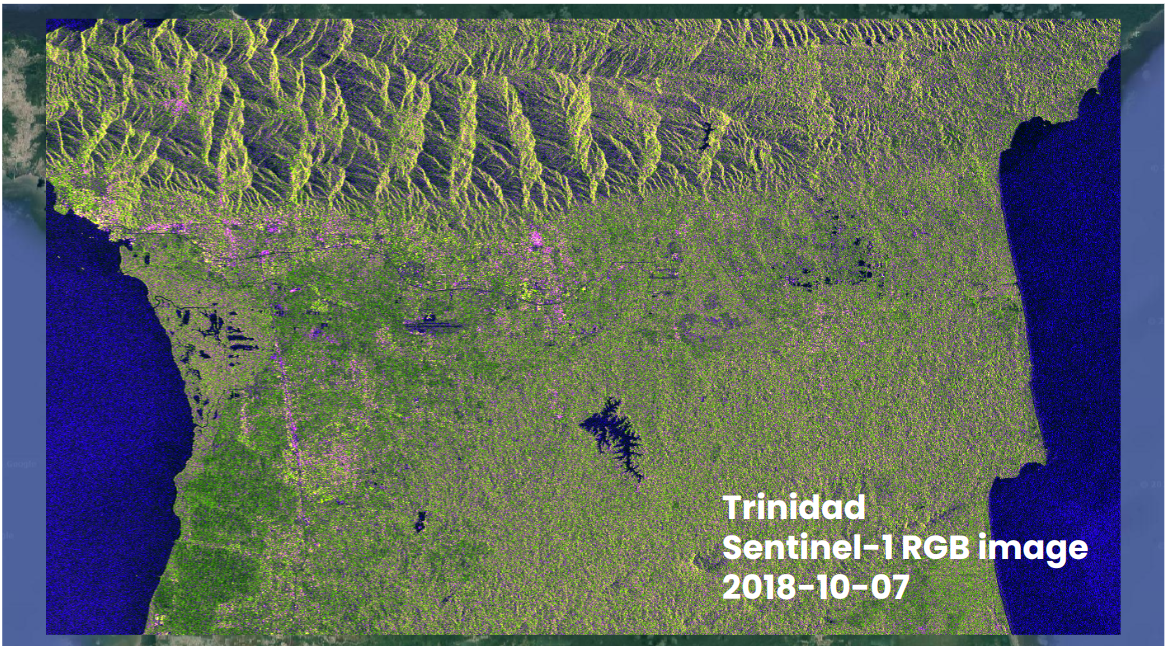

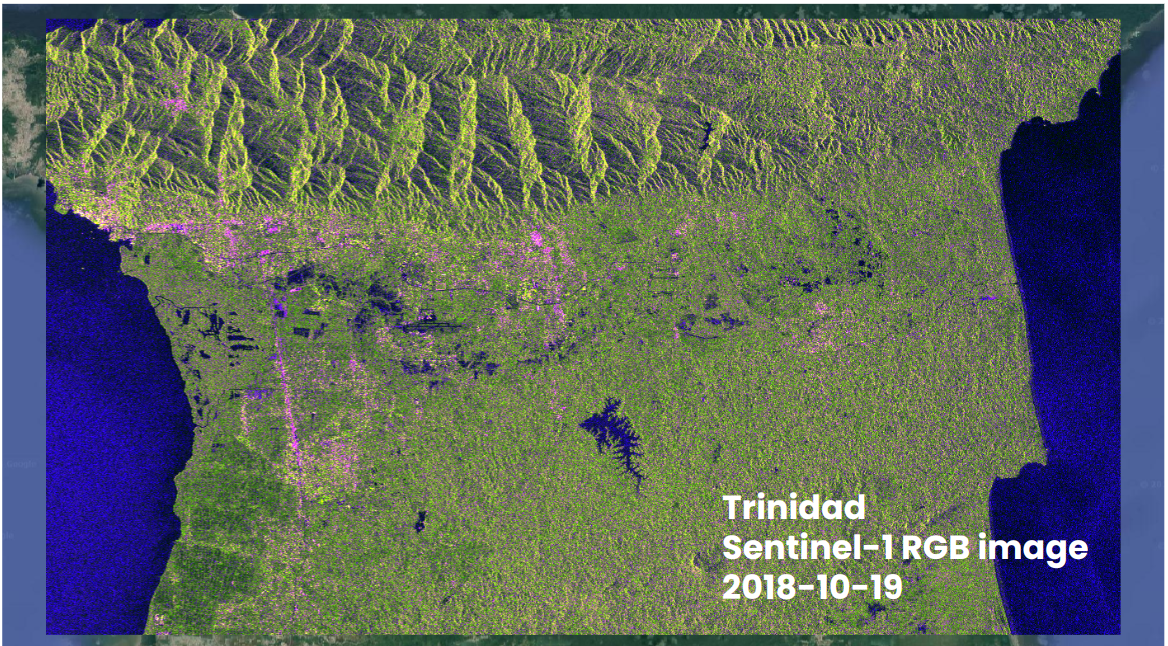

# General Methodology and Workflow

<font face="Calibri" size="3">The workflow of the Sentinel-1-based processing chain, as outlined in the figure below, is composed of the following main elements: 
<ol>
  <li><b>Find relevant SAR data</b> over your area of interest at the <a href="https://search.asf.alaska.edu/#/">Alaska Satellite Facility's SAR archive</a> and <b>Perform geometric and radiometric terrain correction</b> using the RTC processing flow by <a href="https://www.gamma-rs.ch/">GAMMA Remote Sensing</a>,</li>
  <li><b>adaptive and automatic threshold calculation</b> as discussed in the course,</li>
  <li><b>initial flood detection</b> by applying the calculated threshold image wide,</li>
  <li><b>fuzzy-logic-based classification refinement</b>,</li>
  <li><b>final classification into permanent and flood waters</b> using auxiliary data, and</li>
  <li><b>dissemination of the results</b>.</li>
</ol>

<b><i>Step 1 </i></b> of this workflow are operationally implemented in the Alaska Satellite Facility's Hybrid Pluggable Processing Pipeline (HyP3) environment and accessible to the public at the <a href="https://hyp3.asf.alaska.edu/">HyP3 Website</a>. This notebook will focus on Steps 2 and 3. The Sentinel-1 RTC images have already been processed for this Lab. Step 1 can also be accomplished by following this [ASF tutorial](https://storymaps.arcgis.com/stories/2ead3222d2294d1fae1d11d3f98d7c35) about the use of RTC on demand Services.
</font>
<img style="padding: 7px" src="https://courses.edx.org/asset-v1:AlaskaX+SAR-401+3T2020+type@asset+block@Watermappingworkflow2.jpg" width="70%"/>

# Flood Mapping Procedure

## Loading Python Libraries

In [1]:
import glob
import os
from typing import Tuple

import numpy as np
from osgeo import gdal
import pyproj
import pandas as pd
import rasterio

import matplotlib.pyplot as plt
from auxiliary_functions import *

## Load SAR Data Sets to Process

<font face="Calibri" size="3"><b>Reading a SAR Data Stack:</b>

This lab uses a subset of 2 Sentinel-1 SAR images acquired over the island of Trinidad. The images were acquired in Ascending orbit and correspond to Path 164, Frame 31. These images were RTC processed and calibrated to $\sigma_{0}$, expressed in power units.</font>

<font face="Calibri" size="3"><b>Define the parent directory of the directory containing the data and create a directory in which to store the water masks</b></font>

In [2]:
analysis_directory = "tiff/potencia"
os.chdir(analysis_directory)
mask_directory = 'Water_Masks'

if not os.path.exists(mask_directory):
    os.mkdir(mask_directory)
print(f"Current working directory: {os.getcwd()}")

paths = "*_V*.tif*"

tiff_paths = get_tiff_paths(paths)

Current working directory: /media/sseppi/Elements/ASUS/Documentos/T_T/RTC/tiff/potencia


In [3]:
# Print the found GeoTiff datasets
tiff_paths

['20181007_VH.tif', '20181007_VV.tif', '20181019_VH.tif', '20181019_VV.tif']

<font face="Calibri" size="3"><b>Create a dictionary of VV/VH pairs and check it for completeness</b></font>

In [4]:
grouped_pths = group_polarizations(tiff_paths)
if not confirm_dual_polarizations(grouped_pths):
    print("ERROR: AI_Water requires both VV and VH polarizations.")
else:
    print("Confirmed presence of VV and VH polarities for each product.")
    
print(grouped_pths) #uncomment to print VV/VH path pairs

Confirmed presence of VV and VH polarities for each product.
{'20181007_': ['20181007_VH.tif', '20181007_VV.tif'], '20181019_': ['20181019_VH.tif', '20181019_VV.tif']}


# 1. Exploratory analysis and manual thresholding


<font face="Calibri" size="3"> Before proceeding with the implementation of the automated thresholding, we will perform some exploratory and visual analysis of our SAR images, in order to understand how water behaves in each polarization. We will use that information to establish the thresholds manually. 
</font>

In [5]:
# Let's start with the image prior to the flooding:

vh_1 = gdal_read('20181007_VH.tif', ndtype=np.float32)
vv_1 = gdal_read('20181007_VV.tif', ndtype=np.float32)

<font face="Calibri" size="3"> Let's perform some visualization of the images. We can use the _imshow()_ function for this purpose: 
</font>

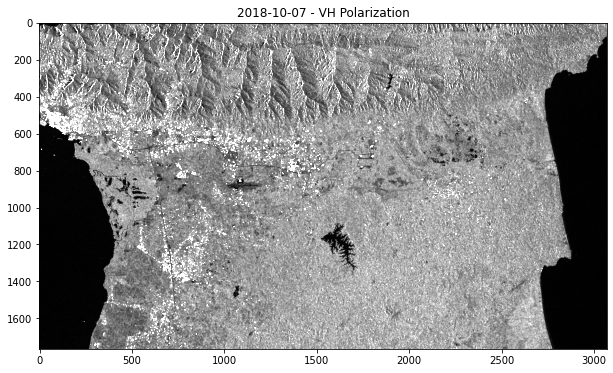

In [6]:
# VH polarization
fig = plt.figure(figsize=(12, 6))
vmin = np.percentile(vh_1, 5)
vmax = np.percentile(vh_1, 95)
plt.imshow(vh_1, cmap = 'gray', vmin = vmin, vmax = vmax)
plt.title("2018-10-07 - VH Polarization")
plt.show()

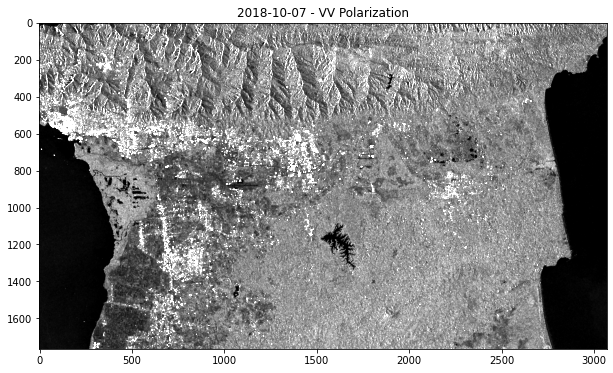

In [7]:
# VV polarization
fig = plt.figure(figsize=(12, 6))
vmin = np.percentile(vv_1, 5)
vmax = np.percentile(vv_1, 95)
plt.imshow(vv_1, cmap = 'gray', vmin = vmin, vmax = vmax)
plt.title("2018-10-07 - VV Polarization")
plt.show()

<font face="Calibri" size="3">
We can also create an RGB visualization by combining these polarimetric channels. In case of dual-pol images such as Sentinel-1, a possible combination is <span style="color:red;">VV</span> (Red), <span style="color:green;">VH</span> (Green), <span style="color:blue;">VV/VH</span> (Blue). When plotting RGB images in Python, it is important to make sure all the channels are scaled to the same numeric range. Therefore, we will use one of our auxiliary functions, called get_rgb().
</font>


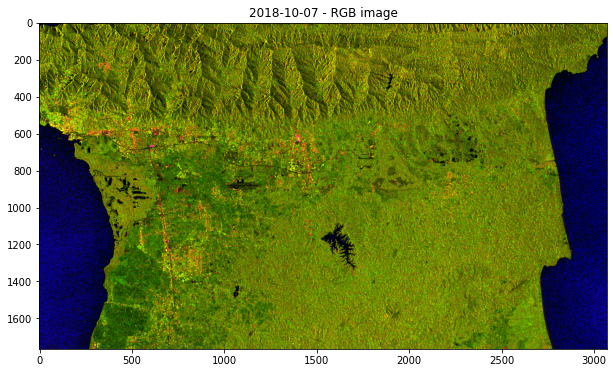

In [8]:
# Mask where vh_1 is zero to avoid errors in division
ratio_vv_vh_1 = np.zeros_like(vv_1)
valid_indices = vh_1 != 0
ratio_vv_vh_1[valid_indices] = vv_1[valid_indices] / vh_1[valid_indices]

rgb0 = np.stack((vv_1,vh_1,ratio_vv_vh_1))
rgb = get_rgb(rgb0, band_list = [1,2,3], p = 2, nodata = 0)

fig = plt.figure(figsize=(12, 6))
plt.imshow(rgb)
plt.title("2018-10-07 - RGB image")
plt.show()

Now, let's use the one of the polarizations to mark some areas of interest and create histograms. First, we are going to use a tool from the OpenCV library which allows us to mark a Region of Interest (ROI) interactively on one of the SAR images. We will use as reference map the VV channel, and try to mark a ROI that comprises both water and land:

In [74]:
import cv2
showCrosshair = False
fromCenter = False
band = scale(vv_1, p = 2)
window_name = "Mark a ROI using mouse + Enter + Keyboard"
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)  # Create a resizable window
cv2.resizeWindow(window_name, 800, 1000)  # Set the window size to 800x600 pixels
roi = cv2.selectROI(window_name, band, fromCenter, showCrosshair)
cv2.waitKey() 
print('ROI:',roi)
print('(column, row, col width, row height)')
cv2.destroyAllWindows()

ROI: (1513, 1138, 55, 64)
(column, row, col width, row height)


Now, let's plot the subsets of the images defined by the selected ROI:

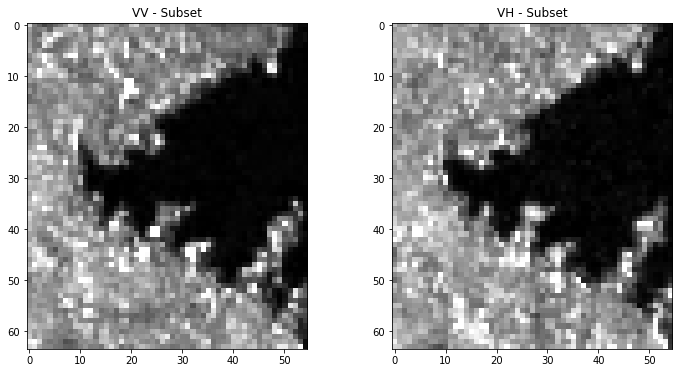

In [75]:
# Extract the ROI xy origin, its width and height
x, y, w, h = roi

# Use the information to crop the images and plot them
plt.figure(figsize = (12,6))
subset_vv = vv_1[y:y+h, x:x+w]
subset_vh = vh_1[y:y+h, x:x+w]
plt.subplot(1,2,1)
plt.imshow(scale(subset_vv, p=2), cmap = 'gray')
plt.title('VV - Subset')
plt.subplot(1,2,2)
plt.imshow(scale(subset_vh, p=2), cmap = 'gray')
plt.title('VH - Subset')
plt.show()

Now, let's look at the histograms. **But** we are goig to express the data in decibels (dB). The numeric range of decibels makes easier the discrimination different peaks in the histogram, and the formula to convert from power values to dB is:

\begin{equation}
  array\_dB = 10*log10(array)
\end{equation}

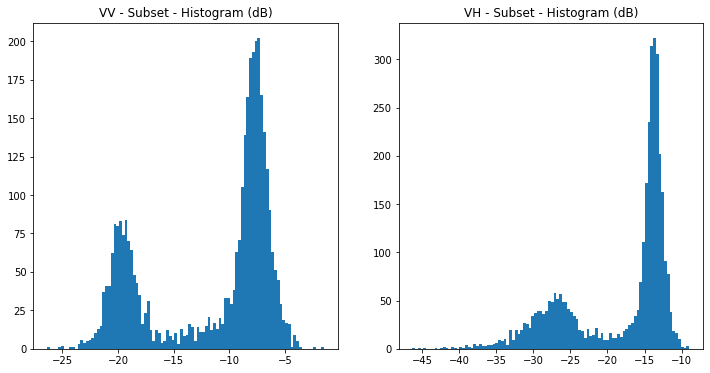

In [76]:
# Convert to dB the subsets:
subset_vv = 10*np.log10(vv_1[y:y+h, x:x+w])
subset_vh = 10*np.log10(vh_1[y:y+h, x:x+w])

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.hist(subset_vv.ravel(), bins = 100)
plt.title('VV - Subset - Histogram (dB)')
plt.subplot(1,2,2)
plt.hist(subset_vh.ravel(), bins = 100)
plt.title('VH - Subset - Histogram (dB)')
plt.show()

If the ROI comprises both water and land, you will probably see two peaks in your histograms. You can manully define a threshold value to separate water from not-water and then build a mask based on that value. Let's see how this work on the VV and VH polarizations:

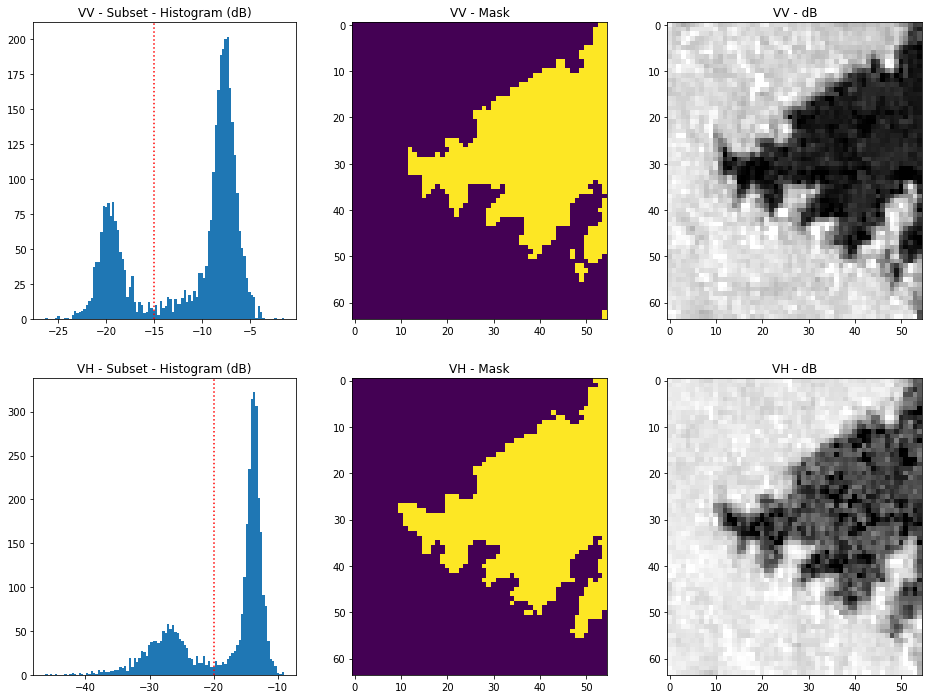

In [77]:
# Set this values according to what you see in the histograms
value_vv = -15
value_vh = -20

# Create the masks
mask_vv = subset_vv <= value_vv
mask_vh = subset_vh <= value_vh

# Plot the results together with the histograms and dB Images
plt.figure(figsize = (16,12))
plt.subplot(2,3,1)
plt.hist(subset_vv.ravel(), bins = 100)
plt.axvline(value_vv, color = 'red', ls = 'dotted')
plt.title('VV - Subset - Histogram (dB)')
plt.subplot(2,3,2)
plt.imshow(mask_vv)
plt.title('VV - Mask')
plt.subplot(2,3,3)
plt.imshow(scale(subset_vv, p=2), cmap = 'gray')
plt.title('VV - dB')
plt.subplot(2,3,4)
plt.hist(subset_vh.ravel(), bins = 100)
plt.axvline(value_vh, color = 'red', ls = 'dotted')
plt.title('VH - Subset - Histogram (dB)')
plt.subplot(2,3,5)
plt.imshow(mask_vh)
plt.title('VH - Mask')
plt.subplot(2,3,6)
plt.imshow(scale(subset_vh, p=2), cmap = 'gray')
plt.title('VH - dB')
plt.show()

Let's see now what happens if we apply these thresholds to the complete scenes:

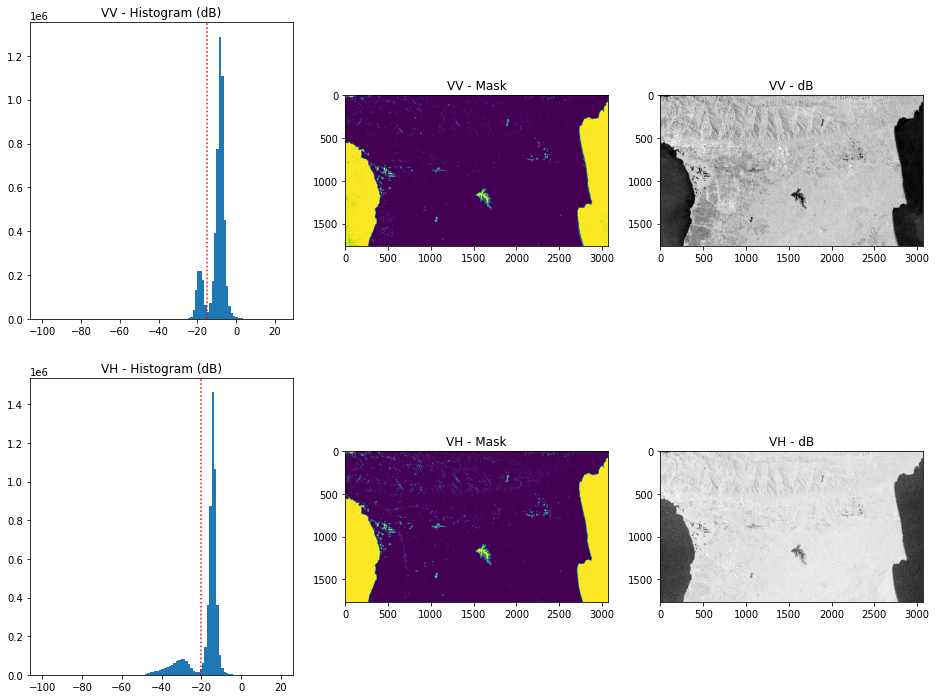

In [78]:
# Create the masks for the complete scene

# Define a small constant to avoid log(0)
epsilon = 1e-10

# Apply log10 safely to vh_1 and vv_1
vh_1_db = 10 * np.log10(np.maximum(vh_1, epsilon))
vv_1_db = 10 * np.log10(np.maximum(vv_1, epsilon))

mask_vv_full = vv_1_db <= value_vv
mask_vh_full = vh_1_db <= value_vh

# Plot the results together with the histograms and dB Images
plt.figure(figsize = (16,12))
plt.subplot(2,3,1)
plt.hist(vv_1_db.ravel(), bins = 100)
plt.axvline(value_vv, color = 'red', ls = 'dotted')
plt.title('VV - Histogram (dB)')
plt.subplot(2,3,2)
plt.imshow(mask_vv_full)
plt.title('VV - Mask')
plt.subplot(2,3,3)
plt.imshow(scale(vv_1_db, p=2), cmap = 'gray')
plt.title('VV - dB')
plt.subplot(2,3,4)
plt.hist(vh_1_db.ravel(), bins = 100)
plt.axvline(value_vh, color = 'red', ls = 'dotted')
plt.title('VH - Histogram (dB)')
plt.subplot(2,3,5)
plt.imshow(mask_vh_full)
plt.title('VH - Mask')
plt.subplot(2,3,6)
plt.imshow(scale(vh_1_db, p=2), cmap = 'gray')
plt.title('VH - dB')
plt.show()

Let's save the results to GeoTiff in order to visualize the results in QGIS:

In [14]:
# We need to read a file as GDAL dataset in order to retrieve georreferencing and projection information to save the masks
f = gdal.Open('20181007_VH.tif')

#Now we save the masks:
write_mask_to_file(mask_vv_full, os.path.join('Water_Masks','mask_vv_full.tif'), f.GetProjection(), f.GetGeoTransform())
write_mask_to_file(mask_vh_full, os.path.join('Water_Masks','mask_vh_full.tif'), f.GetProjection(), f.GetGeoTransform())

<font face="Calibri" size="3"> You will notice there are some areas where the thresholding has failed, such as mountain areas were low-backscatter pixels are confused with water, as well as certain buldings such as the Runaway at Piarco Airport, similar to the screenshots:
</font>

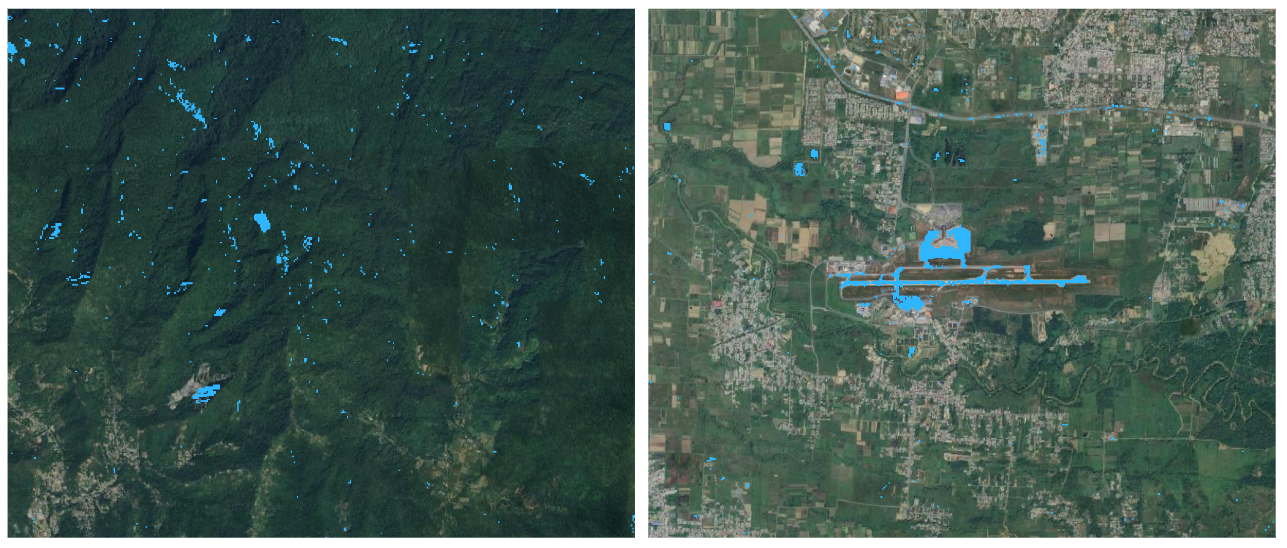

<font face="Calibri" size="3"> However, we can solve this using external data. For this purpose, you have a raster containing a Land Cover Map (LCC) generated by the [Global Land Analysis and Discovery (GLAD) cover](https://glad.umd.edu/dataset/global-land-cover-land-use-v1). The grids containing the raster files can be accesed from [this link](https://storage.googleapis.com/earthenginepartners-hansen/GLCLU_2019/download.html), as well as an excel file cotaining the [legend reference](https://glad.umd.edu/sites/default/files/legend_0.xlsx). There are two versions of the GLAD LCC to be downloaded: The Map (more detailed classes) and Strata products (less classes, grouped in more generic groups). For this Lab, we will use the second product. Te classes we are going to use to mask out the incorrect water-detected pixels are: Dense tree cover (5), Built up (18), and Ocean (19), but you can play with other classes in case you are interested:
    
| Value | Strata                            |     | Value | Strata                            |
|-------|-----------------------------------|-----|-------|-----------------------------------|
| 1     | True desert                       |     | 11    | Wetland open tree cover           |
| 2     | Semi-arid                         |     | 12    | Wetland dense tree cover          |
| 3     | Dense short vegetation            |     | 13    | Wetland tree cover gain           |
| 4     | Open tree cover                   |     | 14    | Wetland tree cover loss, not fire |
| 5     | Dense tree cover                  |     | 15    | Ice                               |
| 6     | Tree cover gain                   |     | 16    | Water                             |
| 7     | Tree cover loss, not fire         |     | 17    | Cropland                          |
| 8     | Salt pan                          |     | 18    | Built-up                          |
| 9     | Wetland sparse vegetation         |     | 19    | Ocean                             |
| 10    | Wetland dense short vegetation    |     | 20    | No data                           |

Source: [GLAD legend](https://glad.umd.edu/sites/default/files/legend_0.xlsx)

We are going to read the GLAD raster called _'GLAD_Trinidad_Crop.tif'_, and build a mask to identify pixels belonging to classes 5, 18 and 19:
</font>

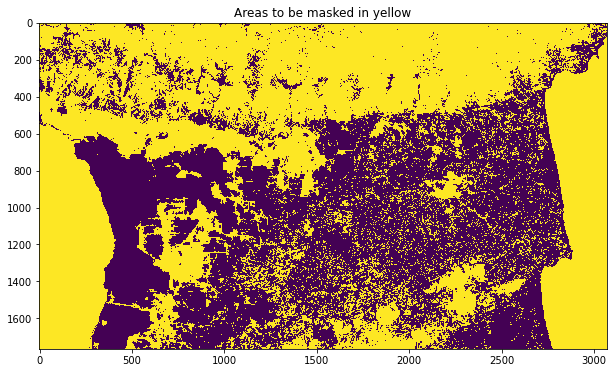

In [15]:
#Read the GLAD raster
GLAD = gdal_read('GLAD_Trinidad_Crop.tif')

# Create Binary GLAD mask
Gmask = (GLAD == 18) | (GLAD == 19) | (GLAD == 5)

# Plot the mask:
plt.figure(figsize = (12,6))
plt.imshow(Gmask, interpolation = 'None')
plt.title('Areas to be masked in yellow')
plt.show()

<font face="Calibri" size="3"> 
Now, we can use this mask to remove the water-detected pixels where there is an overlap with some of these classes (5, 18 or 19). 
</font> 

In [16]:
invalid_pixels = np.where(Gmask)

mask_vv_full_corr = mask_vv_full.copy()
mask_vv_full_corr[invalid_pixels] = False
mask_vh_full_corr = mask_vh_full.copy()
mask_vh_full_corr[invalid_pixels] = False


#Now we save the corrected masks:
write_mask_to_file(mask_vv_full_corr, os.path.join('Water_Masks','mask_vv_full_corr.tif'), f.GetProjection(), f.GetGeoTransform())
write_mask_to_file(mask_vh_full_corr, os.path.join('Water_Masks','mask_vh_full_corr.tif'), f.GetProjection(), f.GetGeoTransform())

<font face="Calibri" size="3">
There is quite room for improvement, but this can handled also with post-procesing techniches such as morphological filtering, which will be addressed at the end of this Notebook.
</font>

## 1.1. Excercise: 

<br>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>1.1. EXERCISE</u>:  </font> Create Water Masks for the other image</b>

<font face="Calibri" size="3"> Repeat the manual thresholding procedure with the image corresponding to 2018-10-19. Save the corrected waters masks to GeoTiff. </font>
</div>
<br>
<hr>

# 2. Flood Mapping using Adaptive Dynamic Thresholding  




<font face="Calibri" size="4"><b>A bit of background on the implemented approach:</b></font>

<font face="Calibri" size="3"><u><b>An automatic tile-based thresholding procedure (Martinis, Twele, and Voigt 2009) is used to generate an land/water classification. The selection of tiles is performed on a bilevel quadtree structure with parent level $L^+$ and child level $L^−$:
    
1. Firstly, the entire data are separated into quadratic non-overlapping parent tiles on level $L^+$ with a size of $100 \times 100$ pixels. Each parent object is further represented by four quadratic child objects on a second level $L^−$. The tile selection process is based on statistical hierarchical relations between parent and child objects. 
2. A number of parent tiles is automatically selected which offer the highest (>95% quantile) coefficient of variation on $L^+$ of the mean backscatter values of the respective child objects on $L^−$. This criterion serves as a measure of the degree of variation within the data and can therefore be used as an indicator of the probability that the tiles are characterized by spatial inhomogeneity and contain more than one semantic class. The selected parent objects should also have a mean individual backscatter value lower than the mean of all parent tiles on $L^+$. This ensures that tiles lying on the boundary between water and no water areas are selected. In case that no tiles fulfil these criteria, the tile size on $L^+$ and $L^−$ is halved and the quantile for the tile selection is reduced to 90% to guarantee a successful tile selection also in data with a relatively low extent of water surfaces or with smaller dispersed water bodies. 
3. To improve the robustness of the automatic threshold derivation the approach restricts the tile selection in Step (3) to only pixels situated in flood-prone regions defined by a Height Above Nearest Drainage (HAND)-based binary Exclustion Mask (HAND-EM). To create HAND-EM, a threshold is applied to HAND to identify non-flood prone areas. A threshold value of $\geq 15m$ is proposed. The HAND-EM further is shrunk by one pixel using an 8-neighbour function to account for potential geometric inaccuracies between the exclude layer and SAR data. Tiles are only considered in case less than 20% of its data pixels are excluded by HAND-EM. **We will also use the generated GLAD mask to avoid tiles being selectec from urban, forest or ocean areas**.
4. Out of the number of the initially selected tiles, a limited number of N parent tiles are finally chosen for threshold computation. This selection is accomplished by ranking the parent tiles according to the standard deviation of the mean backscatter values of the respective child objects. Tiles with the highest values are chosen for $N$. Extensive testing yielded that $N = 5$ is a sufficient number of parent tiles for threshold computation. 
5. A multi-mode Expectation Maximization minimum error thresholding approach is then employed to derive local threshold values using a cost function which is based on the statistical parameterization of the sub-histograms of all selected tiles as bi-modal Gaussian mixture distributions. In order to derive a global (i.e. scenebased) threshold, the locally derived thresholds are combined by computing their arithmetic mean. 
6. Using the dynamically calculated threshold, both the VV and VH scenes are thresholded for water detection
7. The detected water maps are combined for arrive at an intial water mask that can be further refined in post processing. </font> 

## 2.1. Load HAND Layer for your AOI and Create HAND-Exclusion Mask (HAND-EM)

<font face="Calibri" size="3">This notebook uses a prepared Height Above Nearest Drainage (HAND) file that was cut to the same extent as the SAR image time series. A DEM is used to create HAND by calculating the height difference between a particular image pixels and the nearest drainage (such as the nearest river). This data is derived from the [Global 30m HAND dataset](https://github.com/ASFHyP3/OpenData/tree/main/glo-30-hand) and can be accesed through [Amazon Web Services](https://copernicus-dem-30m.s3.amazonaws.com/readme.html). The HAND files  are organized into the same 1 degree by 1 degree grid tiles as the GLO-30 DEM. For example, the tiles used for this practical were:
    
    - https://glo-30-hand.s3.us-west-2.amazonaws.com/v1/2021/Copernicus_DSM_COG_10_N10_00_W062_00_HAND.tif
    - https://glo-30-hand.s3.us-west-2.amazonaws.com/v1/2021/Copernicus_DSM_COG_10_N10_00_W061_00_HAND.tif
    
The provided links offer two sample Notebooks. One to create your own HAND map based on a DEM, and another one to search HAND tiles based on input coordinates.
    
To create the HAND Exclusion Mask (HAND-EM) we then threshold the HAND layer by assuming that pixels with a HAND value > 15 m are unlikely to be flooded. This means, in other words, we assume that flood waters are unlikely to exceed a depth of 15 m. 
</font>

In [17]:
#load HAND and derive HAND-EM
Hthresh = 15

HAND_file="HAND_Trinidad_Crop.tif"
print(f"Selected HAND: {HAND_file}")
try:
    HAND_gT=gdal_get_geotransform(HAND_file)
except AttributeError:
    raise NoHANDLayerException("Remember to select a HAND layer in the previous cell.")
HAND_proj4=get_proj4(HAND_file)
HAND=gdal_read(HAND_file)
hand = np.nan_to_num(HAND)

# Create Binary HAND-EM
handem = hand < Hthresh
handem = handem*1

Selected HAND: HAND_Trinidad_Crop.tif


<font face="Calibri" size="3"><b>Now let's plot HAND and HAND-EM side-by-side</b>. Dark blue regions in the HAND file (left) area areas near drainage systems such as rivers. These areas are most likely to be affected by floods. Areas in red, however, are at higher elevations and less likely to be flooded.

The HAND-EM layer to the right shows pixels unlikely to contain flood waters in black. These pixels are at least 15 m above the nearest drainage system.</font>

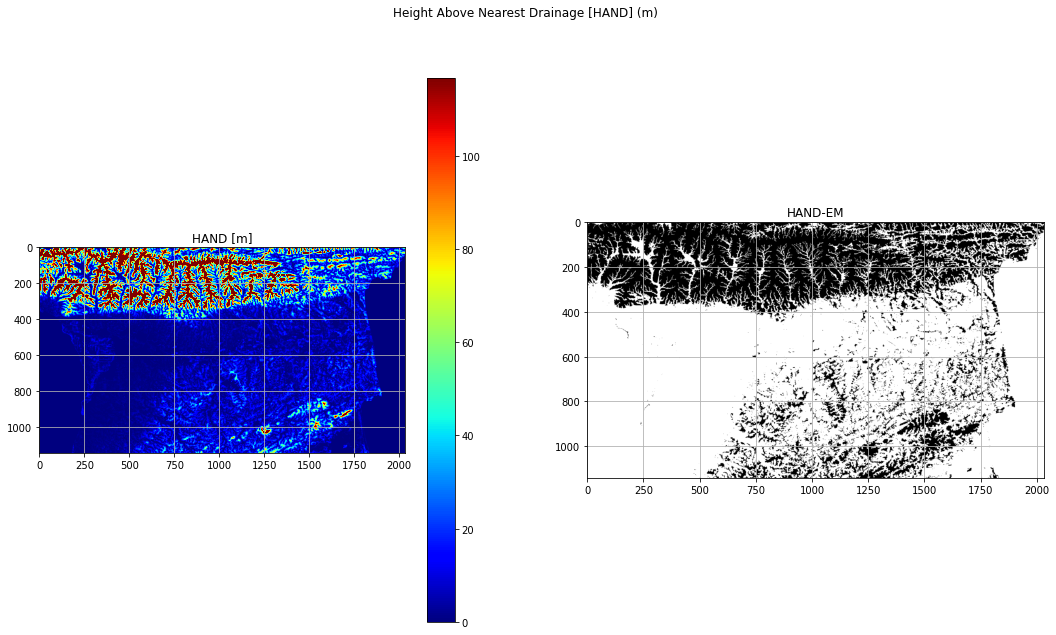

In [18]:
fig = plt.figure(figsize=(18, 10))
plt.suptitle('Height Above Nearest Drainage [HAND] (m)')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
vmin = np.percentile(hand, 5)
vmax = np.percentile(hand, 95)
hh = ax1.imshow(hand, cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_title('HAND [m]')
ax1.grid()
fig.colorbar(hh,ax=ax1)
ax2.imshow(handem, cmap='gray')
ax2.set_title('HAND-EM')
ax2.grid()

## 2.2. Dynamic thresholding


<font face="Calibri" size="3">First, we need to define some parameters for the algorithm:</font>

In [79]:
# define some variables you might want to change
precentile = 0.9        # Standard deviation percentile threshold for pivotal tile selection
tilesize = 20           # Setting tile size to use in thresholding algorithm
tilesize2 = 10
Hpick = 0.9              # Threshold for required fraction of valid HAND-EM pixels per tile
vv_corr = -17.0          # VV threshold to use if threshold calculation did not succeed (in dB)
vh_corr = -24.0          # VH threshold to use if threshold calculation did not succeed (in dB)

<font face="Calibri" size="3">Next, we need to Tile-up the HAND and GLAD data, for which we may have to pad the images first in order to avoid. We will use the _pad_image_ and _tile_image_ auxiliary functions:</font>

In [80]:
# Tile up HAND-EM data
handem_p = pad_image(handem, tilesize)
hand_tiles = tile_image(handem_p,width=tilesize,height=tilesize)
Hsum = np.sum(hand_tiles, axis=(1,2))
Hpercent = Hsum/(tilesize*tilesize)

# Tile up GLAD data
Gmask_padded = pad_image(Gmask, tilesize).astype(bool)
Gmask_tiles = tile_image(Gmask_padded, width=tilesize, height=tilesize)# Identify tiles that have any overlap with GMASK the mask
Gmask_overlap = np.sum(Gmask_tiles, axis=(1, 2)) > 0  # True if tile overlaps with Gmask
valid_tile_indices = np.where(~Gmask_overlap)[0]  # Tiles without overlap


<font face="Calibri" size="3">With all this information, we can proceed wih the threshold calculation and the flood mapping. The following code uses the _dynamyc_threshold_ auxiliary function, and saves the following products:

- Water mask for each polarization and date
- Water mask combination (VH + VV masks) for each date
- Pickfiles: A raster showing the selected tiles for threshold estimation
- VV and VH lists for each date, expressed in decibels
</font>

In [81]:
# Initialize global lists for thresholds and flood areas
vv_thresholds = []
vh_thresholds = []
vv_water_masks = []
vh_water_masks = []
flood_areas = []

# Main processing loop
for i, pair in enumerate(grouped_pths):
    print(f"Processing pair {i+1} of {len(grouped_pths)}")

    # Initialize variables to store VV and VH results
    flood_vh = None
    flood_vv = None
    vh_picks = None
    vv_picks = None
    m_thresh_vv = None
    m_thresh_vh = None

    for tiff in grouped_pths[pair]:
        # Process the current tiff file to generate its flood mask, threshold, and picks
        flood_mask, m_thresh_band, band_picks = dynamic_threshold(
            tiff, tilesize, tilesize2, valid_tile_indices, precentile,
            Hpercent, Hpick, vh_corr if 'vh' in tiff.lower() else vv_corr,
            mask_directory, Gmask_padded
        )

        # Save flood mask as GeoTIFF
        filename, ext = os.path.basename(tiff).split('.')
        outfile = f"{mask_directory}/{filename}_water_mask.{ext}"
        write_mask_to_file(flood_mask, outfile, f.GetProjection(), f.GetGeoTransform())

        # Assign flood mask and other results to the appropriate variables
        if 'vh' in tiff.lower():
            flood_vh = flood_mask
            vh_water_masks.append(flood_vh)
            vh_picks = band_picks
            m_thresh_vh = m_thresh_band
        else:
            flood_vv = flood_mask
            vv_water_masks.append(flood_vv)
            vv_picks = band_picks
            m_thresh_vv = m_thresh_band

    # Save pickfiles for VV and VH
    if vv_picks is not None:
        outfile = f"{mask_directory}/{filename[:-3]}_vv_pickfile.{ext}"
        write_mask_to_file(vv_picks, outfile, f.GetProjection(), f.GetGeoTransform())
        print(f"VV pickfile saved to {outfile}")

    if vh_picks is not None:
        outfile = f"{mask_directory}/{filename[:-3]}_vh_pickfile.{ext}"
        write_mask_to_file(vh_picks, outfile, f.GetProjection(), f.GetGeoTransform())
        print(f"VH pickfile saved to {outfile}")

    # Combine VV and VH flood maps if both are available
    if flood_vh is not None and flood_vv is not None:
        comb = flood_vh + flood_vv  # Combine the two masks
        comb_mask = comb > 0  # Generate a binary combined mask
        flood_comb = np.zeros_like(flood_vh)  # Ensure the combined array is initialized correctly
        flood_comb[comb_mask] = 1  # Mark flooded areas as "1"

        # Save combined flood map
        outfile = f"{mask_directory}/{filename[:-3]}_water_mask_combined.{ext}"
        write_mask_to_file(flood_comb, outfile, f.GetProjection(), f.GetGeoTransform())
        print(f"Combined flood mask saved to {outfile}")

        # Append threshold and flood extent information
        if m_thresh_vv is not None:
            vv_thresholds.append(10.0 * (m_thresh_vv - 30))
        if m_thresh_vh is not None:
            vh_thresholds.append(10.0 * (m_thresh_vh - 30))
    else:
        print(f"Skipping combined flood mask generation for pair {i+1} due to missing VV or VH mask.")

Processing pair 1 of 2
Processing VH band for TIFF: 20181007_VH.tif
Best VH Flood Mapping Threshold [dB]: -27.62
Processing VV band for TIFF: 20181007_VV.tif
Best VV Flood Mapping Threshold [dB]: -14.49
VV pickfile saved to Water_Masks/20181007_vv_pickfile.tif
VH pickfile saved to Water_Masks/20181007_vh_pickfile.tif
Combined flood mask saved to Water_Masks/20181007_water_mask_combined.tif
Processing pair 2 of 2
Processing VH band for TIFF: 20181019_VH.tif
Best VH Flood Mapping Threshold [dB]: -28.89
Processing VV band for TIFF: 20181019_VV.tif
Best VV Flood Mapping Threshold [dB]: -10.46
VV pickfile saved to Water_Masks/20181019_vv_pickfile.tif
VH pickfile saved to Water_Masks/20181019_vh_pickfile.tif
Combined flood mask saved to Water_Masks/20181019_water_mask_combined.tif


## Evaluate Flood Mapping Results

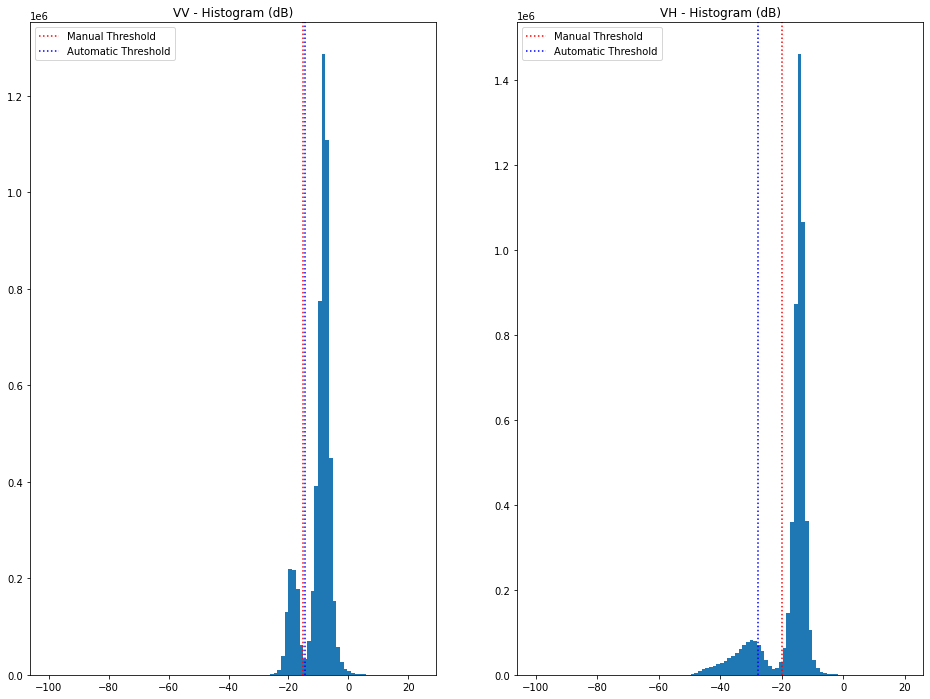

In [82]:
# Create the masks for the complete scene

# Define a small constant to avoid log(0)
epsilon = 1e-10

# Apply log10 safely to vh_1 and vv_1
vh_1_db = 10 * np.log10(np.maximum(vh_1, epsilon))
vv_1_db = 10 * np.log10(np.maximum(vv_1, epsilon))

mask_vv_full = vv_1_db <= value_vv
mask_vh_full = vh_1_db <= value_vh

# Plot the results together with the histograms and dB Images
plt.figure(figsize = (16,12))
plt.subplot(1,2,1)
plt.hist(vv_1_db.ravel(), bins = 100)
plt.axvline(value_vv, color = 'red', ls = 'dotted', label = 'Manual Threshold')
plt.axvline(vv_thresholds[0], color = 'blue', ls = 'dotted', label = 'Automatic Threshold')
plt.title('VV - Histogram (dB)')
plt.legend()
plt.subplot(1,2,2)
plt.hist(vh_1_db.ravel(), bins = 100)
plt.axvline(value_vh, color = 'red', ls = 'dotted', label = 'Manual Threshold')
plt.axvline(vh_thresholds[0], color = 'blue', ls = 'dotted', label = 'Automatic Threshold')
plt.title('VH - Histogram (dB)')
plt.legend()
plt.show()

<br>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>EXERCISE</u>:  </font> Analyze the Quality of the Water Masks</b>

<font face="Calibri" size="3"> Look at different Flood Maps for your 16 dates and evaluate the performance of the flood map. To do so, use the toolbar in the bottom left corner of the image above to zoom in and navigate around: 
- Zoom into the map and look at the details. Are there some pxiels that you would have added to the mask? 
- If you think flood areas were missed, do you seen anything in the underlying image that may explain why a pixel was not detected? </font>
</div>
<br>
<hr>